<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/USE_finetuning_YouTube_clickbait_all_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Thu Jul 22 07:23:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3 MB 11.1 MB/s 
     |████████████████████████████████| 1.6 MB 14.5 MB/s 
     |████████████████████████████████| 636 kB 41.8 MB/s 
     |████████████████████████████████| 99 kB 7.2 MB/s 
     |████████████████████████████████| 211 kB 50.8 MB/s 
     |████████████████████████████████| 679 kB 43.8 MB/s 
     |████████████████████████████████| 1.2 MB 40.9 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 352 kB 51.5 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 37.1 MB 44 kB/s 


#Imports

In [ ]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
import re
from pathlib import Path
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score



import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD


from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configs

##Sentence encoder configs

In [ ]:
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
USE_layer = hub.KerasLayer(
    encoder,
    input_shape=[],
    dtype=tf.string, 
    trainable=True, name='USE_embedding')

##General config

In [ ]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
stop_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/Stop_clickbait/tfrec_data/'
fvc_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/'
tfrec_benchmark_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models'
saved_model_name = f'youtube_clickbait_finetuned_USE_all'
saved_model_path = os.path.join(model_root_path, saved_model_name )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_USE_all'
if not os.path.exists(checkpoint_root_path):
    os.makedirs(checkpoint_root_path)
model_checkpoint_path = os.path.join(checkpoint_root_path, f'youtube_clickbait_finetuned_USE_all_checkpoint' )


BATCH_SIZE = 32  
# Label categories
label_list = [0,1]

init_lr = 1e-3

epochs = 30

#Scripts

In [ ]:
#@title "Utilities [TF Dataset]"
def read_tfrecord(example):
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return text, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [ ]:
#@title "Utilities [Create Model Definition]"
def create_model():

 model = tf.keras.models.Sequential()
 model.add(USE_layer)
 model.add(tf.keras.layers.Dropout(0.2))
 model.add(tf.keras.layers.Dense(128, activation='relu'))
 model.add(tf.keras.layers.BatchNormalization())
 model.add(tf.keras.layers.Dropout(0.2))
 model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 return model

In [ ]:
#@title "Utilities [Model prediction]"
def get_metrics(y_test, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)

def predict_on_test_dataset(model, test_data, BATCH_SIZE=32):
  y_true=[]
  
  for text_feat, labels in test_data:
    for i in range(BATCH_SIZE):
      y_true.append(labels[i].numpy())


  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  vh.plot_cm(y_true, predicted_scores)
  print()

In [ ]:
#@title "Utilities [Visualization]"
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
#@title "Utilities [Gradient function]"
#https://keras.io/examples/vision/gradient_centralization/#implement-gradient-centralization
from tensorflow.keras.optimizers import RMSprop
class GCRMSprop(RMSprop):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads

In [ ]:
class LearningRateDecay:
	def plot(self, epochs, title="Learning Rate Schedule"):
		# compute the set of learning rates for each corresponding
		# epoch
		lrs = [self(i) for i in epochs]
		# the learning rate schedule
		plt.style.use("ggplot")
		plt.figure()
		plt.plot(epochs, lrs)
		plt.title(title)
		plt.xlabel("Epoch #")
		plt.ylabel("Learning Rate")

class StepDecay(LearningRateDecay):
	def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
		# store the base initial learning rate, drop factor, and
		# epochs to drop every
		self.initAlpha = initAlpha
		self.factor = factor
		self.dropEvery = dropEvery
	def __call__(self, epoch):
		# compute the learning rate for the current epoch
		exp = np.floor((1 + epoch) / self.dropEvery)
		alpha = self.initAlpha * (self.factor ** exp)
		# return the learning rate
		return float(alpha)

class PolynomialDecay(LearningRateDecay):
	def __init__(self, maxEpochs=100, initAlpha=0.01, power=1.0):
		# store the maximum number of epochs, base learning rate,
		# and power of the polynomial
		self.maxEpochs = maxEpochs
		self.initAlpha = initAlpha
		self.power = power
	def __call__(self, epoch):
		# compute the new learning rate based on polynomial decay
		decay = (1 - (epoch / float(self.maxEpochs))) ** self.power
		alpha = self.initAlpha * decay
		# return the new learning rate
		return float(alpha)

#Read TFRecord data

In [ ]:
#@title  "Load files & Split into Train and Val"

# read tfrec files from disk storage
read_YouTube_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_stop_clickbait_data = read_tfrec_data(stop_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_fvc_clickbait_data = read_tfrec_data(fvc_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
YouTube_filenames, YouTube_training_filenames, YouTube_validation_filenames, YouTube_testing_filenames = read_YouTube_data.get_tfrec_files()

stop_clickbait_filenames, stop_clickbait_training_filenames,stop_clickbait_validation_filenames, stop_clickbait_testing_filenames = read_stop_clickbait_data.get_tfrec_files()

fvc_filenames, fvc_training_filenames, fvc_validation_filenames, fvc_testing_filenames = read_fvc_clickbait_data.get_tfrec_files()


filenames = YouTube_filenames + stop_clickbait_filenames + fvc_filenames
training_filenames = YouTube_training_filenames + stop_clickbait_training_filenames + fvc_training_filenames
validation_filenames = YouTube_validation_filenames + stop_clickbait_validation_filenames + fvc_validation_filenames

random.shuffle(filenames)
random.shuffle(training_filenames)
random.shuffle(validation_filenames)

print(f'Length FileNames : {len(filenames)} Length Training FileNames : {len(training_filenames)} Length Validation FileNames : {len(validation_filenames)}')

num_train_examples = 974 * len(YouTube_training_filenames) + 500 * len(stop_clickbait_training_filenames) + 100 * len(fvc_training_filenames)
num_total_examples = 974 * len(YouTube_filenames) + 500 * len(stop_clickbait_filenames) + 100 * len(fvc_filenames)

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))



Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
Pattern matches 64 data files. Splitting dataset into 52 training files , 12 validation files and 0 test files
Pattern matches 16 data files. Splitting dataset into 13 training files , 3 validation files and 0 test files
Length FileNames : 94 Length Training FileNames : 77 Length Validation FileNames : 17
With a batch size of 32, there will be 1207 batches per training epoch and 266 batch(es) per validation run.


In [ ]:
#@title  "Load Test and Benchmarking files"
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for testing
read_benchmark_data = read_tfrec_data(tfrec_benchmark_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for benchmarking


testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
benchmarking_filenames, _, _,_ = read_benchmark_data.get_tfrec_files()

len(testing_filenames), len(benchmarking_filenames)

Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files
Pattern matches 4 data files. Splitting dataset into 4 training files , 0 validation files and 0 test files


(2, 4)

#Load TFRecord into TF Dataset

In [ ]:
# create the TF datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)
  benchmark_ds = load_dataset(benchmarking_filenames)

In [ ]:
for i,(text, class_num, label) in enumerate(train_ds.take(10)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'pan dulce is the most delicious thing you need to try', class : 1, label : b'clickbaits'
text : b'u s sees a smaller g m in the future than g m does', class : 0, label : b'nonclickbaits'
text : b'which zodiac should you date based on your favourite game of thrones house', class : 1, label : b'clickbaits'
text : b'lessons i learned from south indian movies', class : 1, label : b'clickbaits'
text : b'oral sex horror stories that ll make you gag', class : 1, label : b'clickbaits'
text : b'which dead grey s anatomy character are you', class : 1, label : b'clickbaits'
text : b'jennifer lawrence wrote a refreshingly honest essay on the hollywood gender pay gap', class : 1, label : b'clickbaits'
text : b'demi lovato did a nude no makeup unretouched photo shoot and it s everything', class : 1, label : b'clickbaits'
text : b'these five questions will determine why you re still single', class : 1, label : b'clickbaits'
text : b'how to get rid of gift cards you ll never use', class : 1, 

In [ ]:
# We need only Text and numeric Label from the dataset
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda text, class_num, label:(text, class_num))
  val_ds = val_ds.map(lambda text, class_num, label:(text, class_num))
  test_ds = test_ds.map(lambda text, class_num, label:(text, class_num))
  benchmark_ds = benchmark_ds.map(lambda text, class_num, label:(text, class_num))

In [ ]:
train_ds.element_spec, val_ds.element_spec, test_ds.element_spec, benchmark_ds.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

In [ ]:
with tf.device('/cpu:0'):
  train_ds = get_batched_dataset(train_ds, train=True)
  val_ds = get_batched_dataset(val_ds)
  test_ds = get_batched_dataset(test_ds)
  benchmark_ds = get_batched_dataset(benchmark_ds)

#Modeling

##Build classifier

In [ ]:
classifier_model = create_model()
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 256,864,129
Trainable params: 256,863,873
Non-trainable params: 256
________________________________________

##Train classifier model

###Compile model

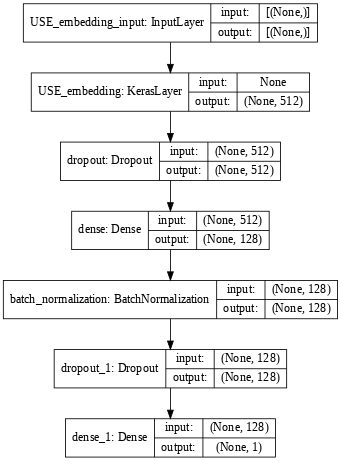

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=5, 
          mode='min', 
          restore_best_weights=True
          )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=model_checkpoint_path,
         save_weights_only=True,
         monitor='val_loss',
         mode='min',
         verbose=1,
         save_best_only=True
        )

METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

#optimizer = optimization.create_optimizer(
#      init_lr=init_lr,
#      num_train_steps=num_train_steps,
#      num_warmup_steps=num_warmup_steps,
#      optimizer_type='adamw'
#      )

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=num_train_steps,
    decay_rate=0.96,
    staircase=True)

optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

###Train

In [ ]:
#@title Load Model weights if available
#if os.path.exists(checkpoint_root_path) & len(os.listdir(checkpoint_root_path))>0:
#  print('loading saved weight')
#  classifier_model.load_weights(model_checkpoint_path)
#else:
#  print('No weight to initialize') 

No weight to initialize


In [ ]:
history = classifier_model.fit(
             x=train_ds,
             validation_data=val_ds,
             epochs=epochs,
             callbacks=[es, mcb]
             )

Epoch 1/30
1217/1217 [==============================] - 336s 248ms/step - loss: 0.1285 - tp: 18161.0000 - fp: 885.0000 - tn: 18907.0000 - fn: 991.0000 - accuracy: 0.9518 - precision: 0.9535 - recall: 0.9483 - auc: 0.9893 - prc: 0.9889 - val_loss: 0.0805 - val_tp: 3934.0000 - val_fp: 164.0000 - val_tn: 4051.0000 - val_fn: 75.0000 - val_accuracy: 0.9709 - val_precision: 0.9600 - val_recall: 0.9813 - val_auc: 0.9963 - val_prc: 0.9960

Epoch 00001: val_loss improved from inf to 0.08047, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_USE_all/youtube_clickbait_finetuned_USE_all_checkpoint
Epoch 2/30
1217/1217 [==============================] - 305s 250ms/step - loss: 0.0213 - tp: 19024.0000 - fp: 141.0000 - tn: 19651.0000 - fn: 128.0000 - accuracy: 0.9931 - precision: 0.9926 - recall: 0.9933 - auc: 0.9994 - prc: 0.9992 - val_loss: 0.0948 - val_tp: 3852.0000 - val_fp: 82.0000 - val_tn: 4133.0000 - va

In [ ]:
# Save model weights
classifier_model.save_weights(model_checkpoint_path)

#Plot train history

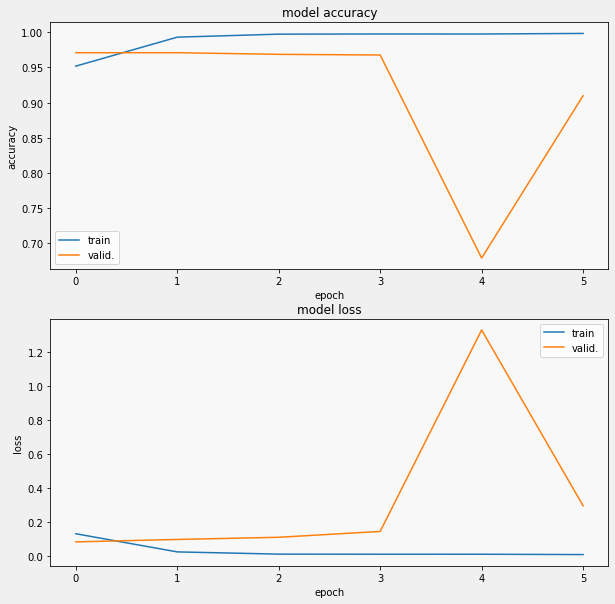

In [ ]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

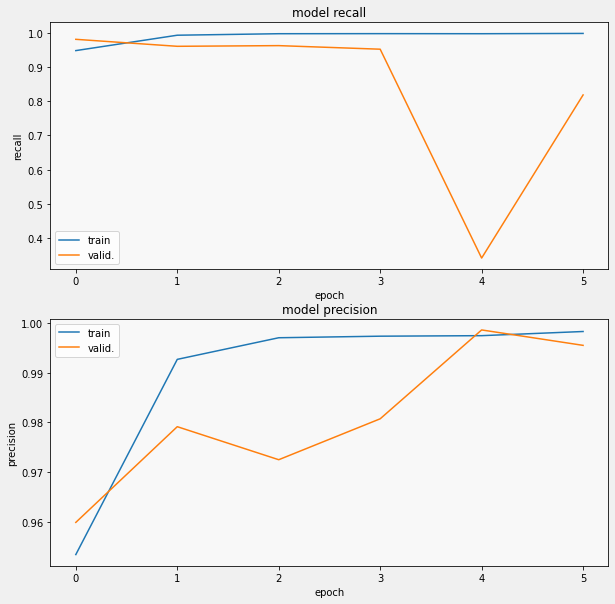

In [ ]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

# Model Inference
We have trained the classifier, now let's use the trained model to infer the test dataset. Beside the test dataset, we also have benchmark dataset that we would also to see the eefectiveness of our model over benchmark dataset on predicting the clickbait's.

##Model Evaluation

###Evaluate Classifier on Test set

In [ ]:
results_test_set = classifier_model.evaluate(test_ds)

for name, value in zip(classifier_model.metrics_names, results_test_set):
  print(name, ': ', value)
print()

60/60 [==============================] - 4s 50ms/step - loss: 0.0815 - tp: 887.0000 - fp: 45.0000 - tn: 978.0000 - fn: 10.0000 - accuracy: 0.9714 - precision: 0.9517 - recall: 0.9889 - auc: 0.9963 - prc: 0.9951
loss :  0.0814959779381752
tp :  887.0
fp :  45.0
tn :  978.0
fn :  10.0
accuracy :  0.9713541865348816
precision :  0.9517167210578918
recall :  0.9888517260551453
auc :  0.9963007569313049
prc :  0.9951176643371582



### Evaluate Classifier on Benchmarking set

In [ ]:
results_benchmarking_set = classifier_model.evaluate(benchmark_ds)

for name, value in zip(classifier_model.metrics_names, results_benchmarking_set):
  print(name, ': ', value)
print()

5/5 [==============================] - 2s 190ms/step - loss: 0.4419 - tp: 71.0000 - fp: 6.0000 - tn: 60.0000 - fn: 23.0000 - accuracy: 0.8188 - precision: 0.9221 - recall: 0.7553 - auc: 0.9262 - prc: 0.9497
loss :  0.44185367226600647
tp :  71.0
fp :  6.0
tn :  60.0
fn :  23.0
accuracy :  0.8187500238418579
precision :  0.9220778942108154
recall :  0.7553191781044006
auc :  0.9261767268180847
prc :  0.9496660232543945



##Export Model for inference

In [ ]:
classifier_model.save(saved_model_path, include_optimizer=False)

##Model prediction

In [32]:
saved_classifier = keras.models.load_model(saved_model_path)

### Prediction for Test set

Accuracy: 0.971354
Precision: 0.951717
Recall: 0.988852
F1 score: 0.969929
ROC AUC: 0.972432
[[978  45]
 [ 10 887]]
Non clickbaits Detected (True Negatives):  978
Non-Clickbaits Detected as Clickbaits (False Positives):  45
Clickbaits Detected as Non-clickbaits (False Negatives):  10
Clickbaits Detected (True Positives):  887
Total Non-clickbaits:  1023
Total Clickbaits:  897



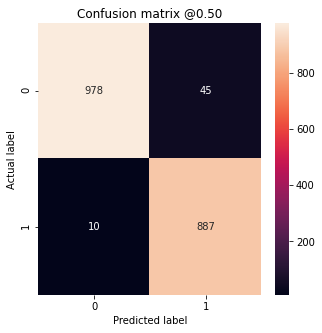

In [33]:
predict_on_test_dataset(saved_classifier, test_ds, BATCH_SIZE=BATCH_SIZE)

### Prediction for Benchmarking set

Accuracy: 0.818750
Precision: 0.922078
Recall: 0.755319
F1 score: 0.830409
ROC AUC: 0.832205
[[60  6]
 [23 71]]
Non clickbaits Detected (True Negatives):  60
Non-Clickbaits Detected as Clickbaits (False Positives):  6
Clickbaits Detected as Non-clickbaits (False Negatives):  23
Clickbaits Detected (True Positives):  71
Total Non-clickbaits:  66
Total Clickbaits:  94



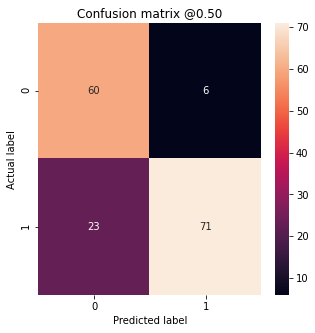

In [34]:
predict_on_test_dataset(saved_classifier, benchmark_ds, BATCH_SIZE=BATCH_SIZE)